In [1]:
import os
import json 
import torch
import pickle
import helpers
import warnings
import numpy as np
import pylab as plt
import networkx as nx
from os.path import join
from copy import deepcopy
from scipy import signal
import sbi.utils as utils
import multiprocessing as mp
from sbi.analysis import pairplot
from vbi.utility import brute_sample
from vbi.Models.St_Lan_numba import Inference
from sbi.utils.user_input_checks import process_prior
warnings.filterwarnings("ignore")

In [2]:
data_path = "output/inferencing"
if not os.path.exists(data_path):
    os.makedirs(data_path)

In [3]:
# Load SC and Distances -------------------------------------------------------
SC = np.loadtxt(join("data/connectivity", "weights.txt"))
Dist = np.loadtxt(join("data/connectivity", "tract_lengths.txt")) / 1000.0
np.fill_diagonal(SC, 0.0)
np.fill_diagonal(Dist, 0.0)

SC = SC/np.max(SC)
SC = np.abs(SC) * 2.0
assert(np.trace(SC) == 0.0)
nn = num_nodes = SC.shape[0]

freq = 40.0
omega = 2*np.pi*freq * np.ones(nn)

params = {
    "G": 0.5,                      # global coupling strength
    "a": -5.0,                     # biforcatio parameter
    "dt": 1e-4,                    # time step [s]
    'sigma_r': 1e-4,               # noise strength
    'sigma_v': 1e-4,               # noise strength
    'omega': omega,                # natural frequency [Hz]
    "fix_seed": 0,
    "velocity": 6.0,

    "t_transition": 1.0,           # transition time [s]
    "t_end": 5.0,                 # end time        [s]

    "weights": SC,                 # weighted connection matrix
    "distances": Dist,             # distance matrix
    "record_step": 2,              # sampling every n step from mpr time series

    "data_path": data_path,        # output directory
}


In [4]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);

NUM_SIMULATIONS = 100
N_JOBS = 10

prior_PAR_min = [800.0, 2.5]
prior_PAR_max = [1700.0, 20.0]

fs = 1.0/(params["dt"]*params["record_step"])

prior_dist = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_PAR_min),
    high=torch.as_tensor(prior_PAR_max))

sol = Inference(params)
prior, _, _ = process_prior(prior_dist)
theta = prior.sample((NUM_SIMULATIONS,)) 


# storing prior samples
torch.save(theta, join(data_path, "theta.pt"))
torch.save(prior, join(data_path, "prior.pt"))
# prior = torch.load(join(data_path, "prior.pt"))
# theta = torch.load(join(data_path, "theta.pt"))

In [5]:
# control parameters for the simulation: list of dictionaries
par_list = []
for i in range(theta.shape[0]):
    par = {"G": theta[i, 0].item(), "V": theta[i, 1].item()}
    par_list.append(par)

In [6]:
# prepare simulation data for sbi
x = torch.as_tensor(helpers.batch_run(params, par_list, n_jobs=N_JOBS),
                    dtype=torch.float32)[:, :3]  # only use first 3 features (try different features)


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [7]:
torch.save(x, join(data_path, "data_x.pt"))
# x = torch.load(join(data_path, "data_x.pt"))

In [8]:
x.shape, x.mean(axis=0).tolist(), x.std(axis=0).tolist(), x.max(axis=0).values.tolist()

(torch.Size([100, 3]),
 [2.5399999618530273, 5.5694391562803244e-14, 1.058443968322137e-13],
 [0.6539700031280518, 1.794982924503783e-14, 4.552413472775664e-14],
 [4.0, 1.245559645007832e-13, 2.1005900740622002e-13])

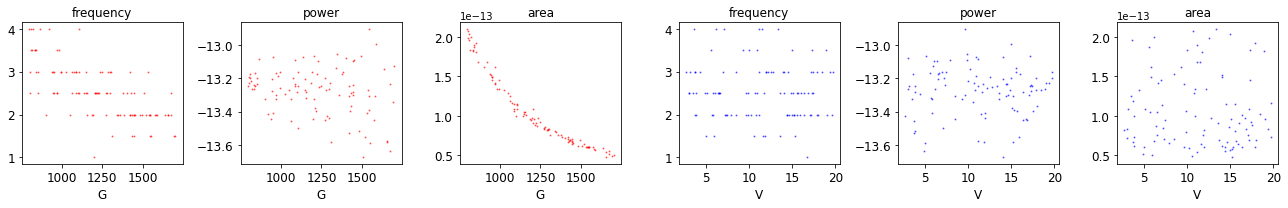

In [9]:
# Plot features ---------------------------------------------------------------
x_ = x.numpy()
fig, ax = plt.subplots(1,6, figsize=(18, 3))
ax[0].plot(theta[:, 0].numpy(), x_[:, 0], 'o', alpha=0.5, color='r', ms=1)
ax[1].plot(theta[:, 0].numpy(), np.log10(x_[:, 1]), 'o', alpha=0.5, color='r', ms=1)
ax[2].plot(theta[:, 0].numpy(), x_[:, 2], 'o', alpha=0.5, color='r', ms=1)
ax[3].plot(theta[:, 1].numpy(), x_[:, 0], 'o', alpha=0.5, color="b", ms=1)
ax[4].plot(theta[:, 1].numpy(), np.log10(x_[:, 1]), 'o', alpha=0.5, color="b", ms=1)
ax[5].plot(theta[:, 1].numpy(), x_[:, 2], 'o', alpha=0.5, color="b", ms=1)

for i in range(3):
    ax[i].set_xlabel("G", fontsize=12)
for i in range(3,6):    
    ax[i].set_xlabel("V", fontsize=12)
for i in range(6):
    ax[i].tick_params(labelsize=12)

[ax[i].set_title("frequency") for i in [0,3]]
[ax[i].set_title("power") for i in [1,4]]
[ax[i].set_title("area") for i in [2,5]]
plt.tight_layout()
plt.savefig(join(data_path, "features.png"), dpi=300)

In [10]:
NUM_SIMULATIONS = theta.shape[0]

In [11]:
# train the neural network
obj = Inference(params)
posterior = obj.train(NUM_SIMULATIONS, prior, x[:, :], theta[:, :], num_threads=4)

 Neural network successfully converged after 223 epochs.train Done in 0 hours 0 minutes 03.022226 seconds


In [12]:
# storing posterior
with open(join(data_path, f"posterior.pickle"), "wb") as cf:
    pickle.dump({"posterior": posterior}, cf)

# load posterior
# posterior = pickle.load(open(join(data_path, f"posterior.pickle"), "rb"))['posterior']


In [13]:
# select an observation point (from empirical data or here just from simulation data)
theta_obs = [1200.0, 20.0]
x_obs = helpers.wrapper_features(params, {"G": theta_obs[0], "V": theta_obs[1]})
x_obs = torch.tensor(x_obs, dtype=torch.float32).reshape(1,-1)

In [14]:
samples = obj.sample_posterior(x_obs[:, :3], 10_000, posterior)
torch.save(samples, join(data_path, "samples.pt"))
# samples = torch.load(join(data_path, "samples.pt"))

Drawing 10000 posterior samples: 10420it [00:00, 192683.43it/s]           


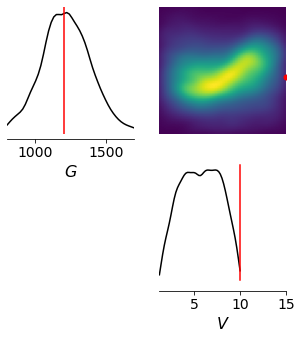

In [15]:
# Plot joint posterior --------------------------------------------------------
limits = [[i, j] for i, j in zip(prior_PAR_min, prior_PAR_max)]

fig, ax = pairplot(
    samples,
    points=[theta_obs],
    figsize=(5, 5),
    limits=limits,
    labels=["G", "V"],
    upper='kde',
    diag='kde',
    # title=f"n = {len(theta)}",
    points_colors="r",
    samples_colors="k",
    points_offdiag={'markersize': 10})

ax[0,0].tick_params(labelsize=14)
ax[1,1].tick_params(labelsize=14)
ax[0,0].margins(y=0)
ax[0,0].set_xlabel(r"$G$", fontsize=16)
ax[1,1].set_xlabel(r"$V$", fontsize=16)
ax[1,1].set_xticks([10, 20, 30])
ax[1,1].set_xticklabels([5, 10, 15]) #!
fig.savefig(join(data_path, "triangleplot.png"), dpi=600, bbox_inches='tight')
fig.savefig(join(data_path, "triangleplot.svg"), dpi=600, bbox_inches='tight')

In [16]:
# find peak of posterior ------------------------------------------------------
from vbi.utility import posterior_peaks
theta_peak = posterior_peaks(samples, labels=["G", "V"])
print(theta_peak)

# then we can check the posterior at the peak
_par = deepcopy(params)
_par["G"] = theta_peak[0]
_par["V"] = theta_peak[1]
data_peak = helpers.simulator(_par)

[1222.435960419324, 14.641313815603452]


In [17]:
# posterior predictive check ...
# plot time series and PSD of peak and compare with observation point ...